# DESARROLLO DE MODELOS PREDICTIVOS PARA LA CLASIFICACIÓN DE RIESGOS CREDITICIOS

En este notebook se presentarán las implementaciones de los 4 modelos predictivos propuestos en el paper "":
- Árbol de decisión CART
- Random Forest
- K-Nearest Neighbors
- Neural Networks

## ESTRUCTURA
Este trabajo se estructurará de acuerdo a las fases descritas en el framework CRISP DM:
1. Comprensión del negocio
2. Comprensión de los datos
3. Preparación de los datos
4. Modelado
5. Evaluación
6. ~~Despliegue (ausente)~~


## 1. COMPRENSIÓN DEL NEGOCIO

En los servicios financieros, específicamente en la atención a una solicitud de crédito para un fin específico, es necesaria la evaluación del solicitante para determinar si este podrá cancelar las cuotas o deudas que conlleva el crédito. Para ello, las entidades financieras se basan en 5 factores: Carácter, Capacidad, Capital, Colateral, Condiciones.

Estos cinco factores indican la estabilidad laboral del solicitante por medio de antecedentes, si posee solvencia económica para pagar el préstamo (proporción entre deudas e ingresos), la diferencia entre sus valores activos y pasivos, los activos que pueden ser expropiados si no cumple con el pago, y las circunstancias externas que puedan afectar la situación financiera del solicitante. Cabe aclarar que estos 5 factores son básicos para una evaluación, por lo que las entidades pueden aumentar y modificar factores para una evaluación más exhaustiva.

En este caso, solo se cuenta con data de 9 atributos de los solicitantes, por lo que no se podrá suplir las 5 Cs detalladas en su totalidad, pero sí se podrá observar cuáles de estos 9 atributos son los que influyen más en la decisión de clasificar a un solicitante como Riesgo Bueno o Riesgo Malo, y relacionarlos con los 5 factores descritos.

### OBJETIVOS

El objetivo de este trabajo es el de implementar 4 modelos predictivos de clasificación, evaluarlos con métricas para clasificación y comparar los resultados para determinar cuáles de estos cuatro puede ser utilizado como predictor en la evaluación de riesgos crediticios.

Además, se identificarán cuáles han sido los atributos más influyentes y confirmar que estos se basan en los 5 factores detallados.

## 2. COMPRENSIÓN DE LOS DATOS

### RECOPILACIÓN

La data utilizada para este trabajo proviene de [...], pero se está trabajando con una derivada de ..., ya que esta última presenta solo los atributos realmente útiles. Es decir, ya se ha realizado un preprocesamiento de la data en cuestión de la selección de los atributos en base al criterio de ... .

### COMPOSICIÓN

Se procede a analizar la data en base a sus atributos y a las 1000 observaciones:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv( 'data/german_credit_data.csv', index_col=0)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
#Número de filas y columnas
data.shape

(1000, 10)

#### DATOS NULOS PRESENTES EN LA DATA
Si se analizan los tipos de datos de los atributos, observamos que 6 de 9 son de tipo `object`, los cuales son propensos a presentar datos nulos, por lo que se analizarán si se ha representado correctamente o no a un dato nulo dentro de las observaciones.

In [5]:
#Tipo de datos en la tabla
data.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

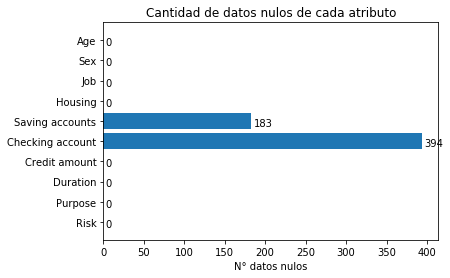

In [6]:
#Cantidad de datos nulos en las columnas

fig, ax = plt.subplots()
x_null, y_null = data.columns, data.isna().sum()

ax.barh(x_null, y_null)
ax.set_title("Cantidad de datos nulos de cada atributo")
ax.invert_yaxis()
ax.set_xlabel("N° datos nulos")
for i, v in enumerate(y_null):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='regular')

plt.show()

Como se intuía, las clases que presentan mayor cantidad de datos nulos son `Saving accounts` y `Checking account`. Se presentan entonces todas las clases de los atributos que son de tipo `object`:

In [7]:
# información única en las columnas de datos discretos
for col in data.select_dtypes(include="object"):
    print(f"{col:16}: ", end=""), print(*(data[col].unique()), sep=", ")

Sex             : male, female
Housing         : own, free, rent
Saving accounts : nan, little, quite rich, rich, moderate
Checking account: little, moderate, nan, rich
Purpose         : radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others
Risk            : good, bad


~~__OBSERVACIÓN:__ A pesar de que no se presentan los datos nulos como únicos, se puede apreciar que en las columnas `Checking accounts` y `Saving accounts` presentan el dato único `nan`, lo que indicaría que las columnas podrían alvergar otro formato de indicar que sus observaciones presentan datos nulos.~~

#### ATRIBUTO JOB COMO TIPO ENTERO

Analizamos entonces toda la data entera, y se puede apreciar que el atributo `Job`, a pesar de no ser de tipo `object`, presenta 4 valores únicos. Esto se debe a que cada número describe al solicitante de la siguiente manera:
- 0 - unskilled and non-resident
- 1 - unskilled and resident
- 2 - skilled
- 3 - highly skilled

In [8]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

#### BALANCE DE CLASES EN TARGET

Según la gráfica, el 70% de los datos corresponden a la categoría de Riesgo Bueno. El desbalance entre las dos clases del target es evidente, pero no en extremo. Sin embargo, se optará por realizar las métricas de precisión y *recall*, además de una representación gráfica como la curva ROC, para todos los modelos de clasificación que se implementen y observar quién modela mejor los datos.

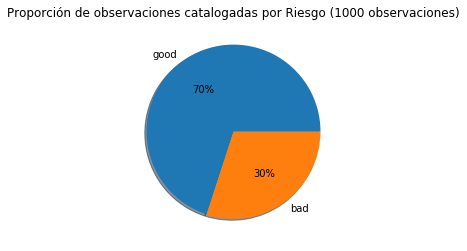

In [9]:
fig, ax = plt.subplots()
ax.pie(data['Risk'].value_counts(), autopct="%.0f%%", labels=data["Risk"].unique(), shadow=True)
ax.set_title("Proporción de observaciones catalogadas por Riesgo (1000 observaciones)")
plt.show()

### CORRELACIÓN

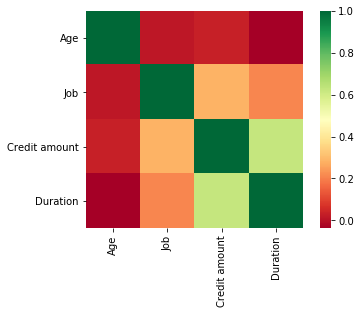

In [14]:
# sns.heatmap(data.corr(), square=True, cmap='RdYlGn')

### CONCLUSIONES DE LA DATA OBSERVADA

1. En los atributos disponibles, se encuentra `Sex`, al cual no se le considerará como un atributo necesario
2. El atributo `Job` se está representando como `int`, pero se le considerará como **categórico**
3. Los tipos de los atributos son los siguientes:
    - __nominal__: Sex, Housing, Job, Purpose, Risk
    - __ordinal__: Saving accounts, Checking account
    - __cardinal__: Age, Credit amount, Duration
4. De acuerdo al tipo del atributo, se normalizarán y modificarán para un mejor procesamiento al momento de entrenar a los modelos
4. Se han encontrado datos nulos en los atributos `Saving accounts` y `Checking account`, siendo este último el que presenta alrededor de 40% de data faltante, por lo que se considera aplicar métricas además del _accuracy_.

## 2. PREPARACIÓN DE LOS DATOS


### Eliminación de atributo Sex
Se eliminará el atributo `Sex` con el fin de evitar de que el modelo de clasificación considere el sexo de un solicitante para asignarle un Riesgo Bueno o Riegos Malo.

In [16]:
clean_data = data.drop(labels="Sex", axis=1, inplace=False)
clean_data.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,2,own,NaN,little,1169,6,radio/TV,good
1,22,2,own,little,moderate,5951,48,radio/TV,bad
2,49,1,own,little,NaN,2096,12,education,good
3,45,2,free,little,little,7882,42,furniture/equipment,good
4,53,2,free,little,little,4870,24,car,bad


### Llenado de datos nulos
Los atributos `Saving accounts` y `Checking account` presentan datos nulos en sus registros, por lo que se utilizará la moda de cada una para poder llenarlas ya que son de tipo categórico.

In [19]:
print("Moda de Saving accounts : ", clean_data["Saving accounts"].mode()[0])
print("Moda de Checking account: ", clean_data["Checking account"].mode()[0])

Moda de Saving accounts :  little
Moda de Checking account:  little


In [20]:
clean_data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
clean_data['Checking account'].fillna(data['Checking account'].mode()[0], inplace=True)

In [23]:
clean_data.isna().sum()

Age                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

### Transformación de datos cualitativos a cuantitativos

Una vez tenemos los datos sin valores faltantes, procedemos a representarlos numéricamente para que los modelos a implementar puedan utilizarlos como inputs para sus algoritmos. En este caso, se convertirán los siguientes atributos:
- ~~Sex~~ (ha sido eliminada)
- Housing
- Saving accounts
- Checking account
- Purpose
- Risk

In [25]:
from sklearn.preprocessing import LabelEncoder 

def encode_features(pre_data):
    features = ['Housing','Saving accounts','Checking account','Purpose', 'Risk']

    for feature in features:
        le = LabelEncoder()
        le = le.fit(pre_data[feature])
        pre_data[feature] = le.transform(pre_data[feature])

    return pre_data
    
clean_data = encode_features(clean_data)
clean_data.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,2,1,0,0,1169,6,5,1
1,22,2,1,0,1,5951,48,5,0
2,49,1,1,0,0,2096,12,3,1
3,45,2,0,0,0,7882,42,4,1
4,53,2,0,0,0,4870,24,1,0


Ahora se tiene a todos como datos numéricos, de los cuales `Age`, `Credit amount` y `Duration` no son categóricos, pero que en los modelos se trabajarán con intervalos.

In [26]:
clean_data.dtypes

Age                 int64
Job                 int64
Housing             int32
Saving accounts     int32
Checking account    int32
Credit amount       int64
Duration            int64
Purpose             int32
Risk                int32
dtype: object

## 3. MODELADO
Los modelos propuestos para la clasificación son los siguientes:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors

Para el entrenamiento, se utilizará la siguiente data de entrenamiento:

In [30]:
from sklearn.model_selection import train_test_split


x = clean_data.drop('Risk',axis=1).values
y = clean_data['Risk'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=7)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (700, 8)
Validation shape: (300, 8)


### LOGISTIC REGRESSION

### RANDOM FOREST

### K-NEAREST NEIGHBORS

## 4. EVALUACIÓN

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=50, n_jobs=-1, warm_start=True)
rfc.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [20]:
rfc.score(x_train, y_train)

0.92375

In [21]:
rfc.score(x_val, y_val)

0.725

#### Usando KFold

In [22]:
from sklearn.model_selection import KFold
NSplits = 10
kf = KFold(n_splits=NSplits)
kf.get_n_splits(x)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [23]:
from sklearn import metrics

In [24]:
AccTotal = 0

for train_index, test_index in kf.split(x):
    X_train, X_test = x.values[train_index], x.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    
    rfcl = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=50, n_jobs=-1, warm_start=True, random_state=0)
    rfcl.fit(X_train, Y_train)

    Y_pred = rfcl.predict(X_test)
    AccFolder = metrics.accuracy_score(Y_test, Y_pred)*100
    print("Accuracy Folder", AccFolder)
  
    AccTotal += AccFolder
  
print("Accuracy General:", AccTotal/NSplits)


Accuracy Folder 81.0
Accuracy Folder 68.0
Accuracy Folder 78.0
Accuracy Folder 76.0
Accuracy Folder 75.0
Accuracy Folder 63.0
Accuracy Folder 73.0
Accuracy Folder 75.0
Accuracy Folder 70.0
Accuracy Folder 70.0
Accuracy General: 72.9


### Tercer Modelo: KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 18, p=3)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_val)
print(metrics.accuracy_score(y_val,y_pred)*100)


70.5


### Cuarto Modelo: Redes Neuronales

In [88]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (100,),solver='sgd', learning_rate='adaptive')
mlp.fit(x_train, y_train)    

print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_val, y_val))


Training set score: 0.691250
Test set score: 0.735000


## Características más importantes

### Árbol de decisión

In [381]:
columnsNames = data.columns.values
listOfColumnNames = list(columnsNames)

for feature in zip(listOfColumnNames, dtc.feature_importances_):
    print(feature)

('Age', 0.18947256184974318)
('Sex', 0.007757241442696397)
('Job', 0.050646120681734096)
('Housing', 0.08496466128453149)
('Saving accounts', 0.041621492235041864)
('Checking account', 0.03242567838939556)
('Credit amount', 0.34561915255006725)
('Duration', 0.1736143669672264)
('Purpose', 0.07387872459956382)


In [382]:
from sklearn.feature_selection import SelectFromModel

select_featuresDT = SelectFromModel(dtc, threshold=0.09)
select_featuresDT.fit(x_train, y_train)

for feature_list_index in select_featuresDT.get_support(indices=True):
    print(listOfColumnNames[feature_list_index])

Age
Credit amount
Duration


### Random Forest

In [383]:
for feature in zip(listOfColumnNames, rfc.feature_importances_):
    print(feature)

('Age', 0.1953912034899732)
('Sex', 0.036290389822295044)
('Job', 0.06066254041826068)
('Housing', 0.05407072826456996)
('Saving accounts', 0.05382532392052596)
('Checking account', 0.046923676812187363)
('Credit amount', 0.28628259835740943)
('Duration', 0.17106109001863412)
('Purpose', 0.09549244889614414)


In [385]:
select_featuresRT = SelectFromModel(rfc, threshold=0.09)
select_featuresRT.fit(x_train, y_train)

for feature_list_index in select_featuresRT.get_support(indices=True):
    print(listOfColumnNames[feature_list_index])

Age
Credit amount
Duration
